In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Cross Validation

## TimeGapSplit

We allow for a timeseries split that contains a gap.

You won't always need it, but sometimes you consider these two situations;

- If you have multiple samples per timestamp: you want to make sure that a timestamp doesn’t appear at the same time in training and validation folds.
- If your target is looking $x$ days ahead in the future. In this case you cannot construct the target of the last x days of your available data. It means that when you put your model in production, the first day that you are going to score is always x days after your last training sample, therefore you should select the best model according to that setup. In other words, if you keep that gap in the validation, your metric might be overestimated because those first x days might be easier to predict since they are closer to the training set. If you want to be strict in terms of robustness you might want to replicate in the CV exactly this real-world behaviour, and thus you want to introduce a gap of x days between your training and validation folds.

TimeGapSplit provides 3 parameters to really reproduce your production implementation in your cross-validation schema. We will demonstrate this in a code example below. 

#### Examples

Let's make some random data to start with.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklego.model_selection import TimeGapSplit

In [3]:
df = (pd.DataFrame(np.random.randint(0, 30, size=(30, 4)), columns=list('ABCy'))
      .assign(date=pd.date_range(start='1/1/2018', end='1/30/2018')[::-1]))
print(df.shape)

# For performance testing
if False:
    df = pd.concat([df]*50000, axis=0)
    df = df.reset_index(drop=True)
    df.index = df.index + 22
    print(df.shape)

(30, 5)


In [4]:
df.head()

,A,B,C,y,date
0,8,13,3,19,2018-01-30
1,19,20,28,1,2018-01-29
2,7,24,25,21,2018-01-28
3,23,7,7,8,2018-01-27
4,20,7,14,7,2018-01-26


**Example 1**

In [5]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=2),
                  gap_duration=timedelta(days=1))

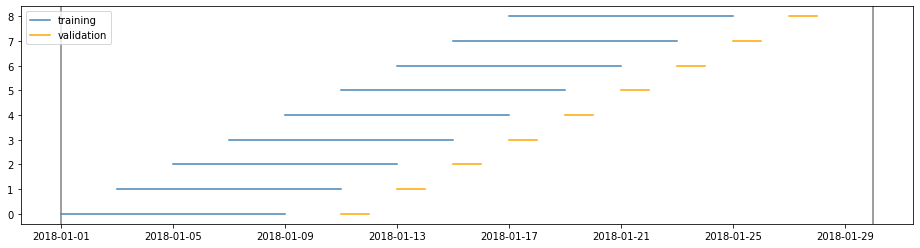

In [6]:
cv.plot(df)

**Example 2**

In [7]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=5),
                  gap_duration=timedelta(days=1))

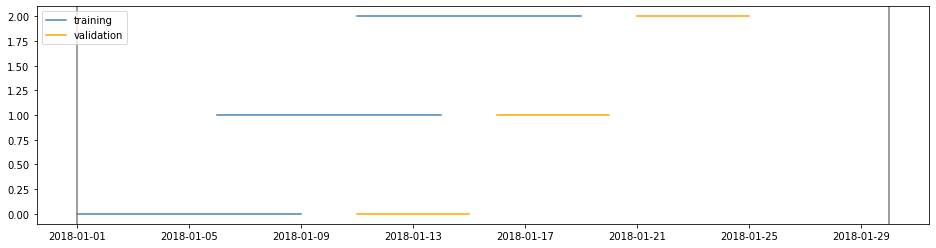

In [8]:
cv.plot(df)

In [9]:
cv.summary(df)

,End date,Period,Start date,Unique days,nbr samples
"(0, train)",2018-01-09,8 days,2018-01-01,9.0,9.0
"(0, valid)",2018-01-15,4 days,2018-01-11,5.0,5.0
"(1, train)",2018-01-14,8 days,2018-01-06,9.0,9.0
"(1, valid)",2018-01-20,4 days,2018-01-16,5.0,5.0
"(2, train)",2018-01-19,8 days,2018-01-11,9.0,9.0
"(2, valid)",2018-01-25,4 days,2018-01-21,5.0,5.0
